# **Advance Lane Line Finding** 

***
In this project, the goal is to identify the lane boundaries in a video from a front-facing camera on a car. The camera calibration images, test road images, and project videos are available in the project repository. 

---
Steps:
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply the distortion correction to the raw image.  
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view"). 
* Detect lane pixels and fit to find lane boundary.
* Determine curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [32]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import os
import ntpath
%matplotlib inline

## Camera Calibration and Undistortion

In [33]:
###############################
# Utility Functions
###############################

# Calibration
def camera_calibration():
    nx = 9 # of inner corners in x
    ny = 6 # of inner corners in y
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            directory = 'output_images/1_corners_found/'
            if not os.path.exists(directory):
                os.makedirs(directory)
            write_name = directory+'corners_found'+str(idx)+'.jpg'
            cv2.imwrite(write_name, img)
    cv2.destroyAllWindows()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    return mtx, dist

# Undistortion 
def cal_undistort(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, None)
    return undist

In [34]:
# Camera Calibration
mtx, dist = camera_calibration()

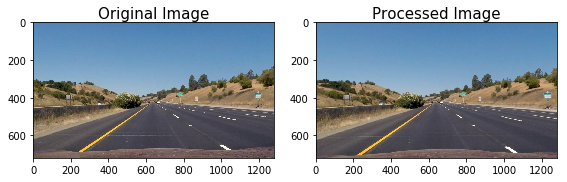

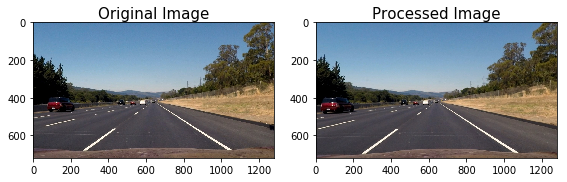

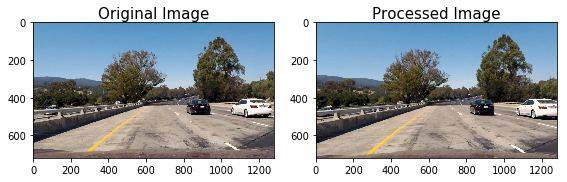

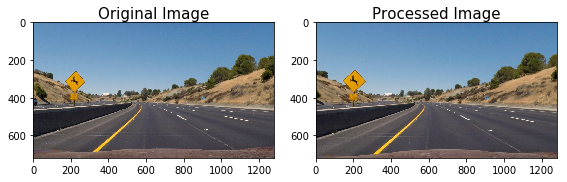

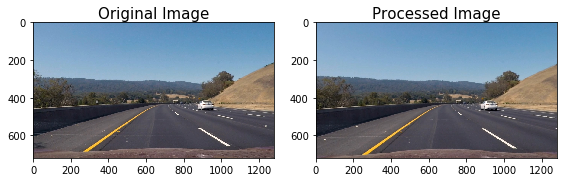

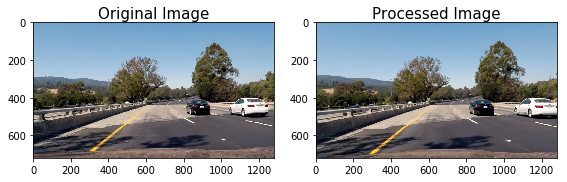

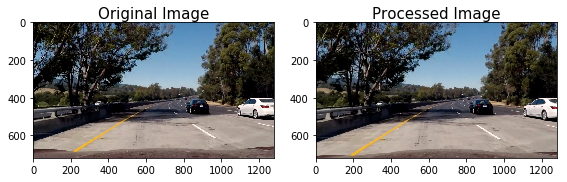

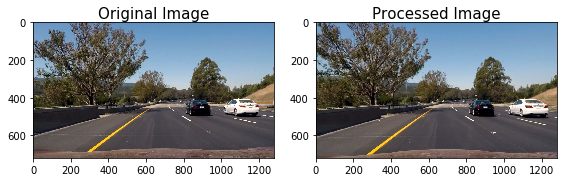

In [35]:
# Test camera calibration and undistortion

#Test on checker images
# images = glob.glob('camera_cal/*.jpg')

#Test on test_images
images = glob.glob('test_images/*.jpg')
images_org = []
images_undist = []

for idx, fname in enumerate(images):
    image = cv2.imread(fname)
    processed_img = cal_undistort(image, mtx, dist)
    images_org.append(image)
    images_undist.append(processed_img)
    
# Plot the Processed_images
# Plot the Processed_images
for image_in, image_out in zip(images_org,images_undist):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
    f.tight_layout()
    ax1.imshow(cv2.cvtColor(image_in, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=15)
    ax2.imshow(cv2.cvtColor(image_out, cv2.COLOR_BGR2RGB))
    ax2.set_title('Processed Image', fontsize=15)

*** 
The difference is obvious when comparing the processed checker image with the original image. But when testing on the test images, the diference are suble, it's slightly noticiable close to the edges. 
***

## Color and Gradient Transformation

In [36]:
###############################
# Utility Functions
###############################
# Gradient threshold 
def abs_sobel_thresh(img, orient='x', thresh=(0, 255), sobel_ksize =5):
    # Convert to grayscale
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_ksize))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_ksize))
   
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

# Color threshold 
def color_thresh(img, channel = 's', thresh=(0, 255)):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    # 3) Return a binary image of threshold result
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    
    if channel=='h':
        out_ch = hls[:,:,0]
    if channel=='l':
        out_ch = hls[:,:,1]
    if channel=='s':
        out_ch = hls[:,:,2]

    binary_output = np.zeros_like(out_ch)
    binary_output[(out_ch > thresh[0]) & (out_ch <= thresh[1])] = 1
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    assert (sobel_kernel%2==1)
    # 1) Convert to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    dx_img = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    dy_img = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_dx_img = np.absolute(dx_img)
    abs_dy_img = np.absolute(dy_img)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir_dimg = np.arctan2(abs_dy_img, abs_dx_img)
    # 5) Create a binary mask where direction thresholds are met
    img_mask = np.zeros_like(dir_dimg)
    img_mask[(dir_dimg>thresh[0]) & (dir_dimg<thresh[1])]=1
    # 6) Return this mask as your binary_output image
    binary_output = img_mask
    return binary_output

def Color_and_Gradient_Thresh(img, s_thresh, sx_thresh, sobel_ksize):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    
    # AOI (area of interest) mask - we only care about lower part of the image
    size_x, size_y, size_ch = hls.shape
    hls[0:size_x//2,:,:] = 0
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Luma threshold
    l_binary = np.zeros_like(l_channel)
    l_binary[l_channel>20]=1

    # Sobel x on L channel
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=sobel_ksize) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold Saturation color channel
    s_binary = np.zeros_like(s_channel)
    scaled_s_ch = np.uint8(255*s_channel/np.max(s_channel))
    s_binary[(scaled_s_ch >= s_thresh[0]) & (scaled_s_ch <= s_thresh[1])] = 1
    
    # Gradients direction 
    dir_binary = dir_threshold(img, sobel_kernel=sobel_ksize, thresh=(np.pi/7, np.pi/3))

    # Stack each channel
    color_binary = np.dstack((dir_binary, sxbinary, s_binary))
    color_binary = np.dstack((np.zeros_like(dir_binary), np.zeros_like(sxbinary), s_binary))

    binary = np.zeros_like(dir_binary)
    binary[((sxbinary==1) | (s_binary==1)) & (l_binary==1)] = 1
    return binary

In [37]:
# Test Color_and_Gradient_Thresh
def preprocessing(image, s_thresh=(180, 255), sx_thresh=(40, 100), sobel_ksize=5):
    # undistort the raw image
    undist = cal_undistort(image, mtx, dist)    
    # color and gradient transformation
    color_binary = Color_and_Gradient_Thresh(undist, s_thresh, sx_thresh,sobel_ksize)
    return color_binary

(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)


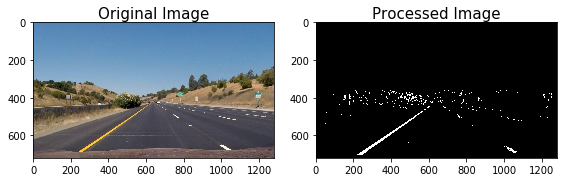

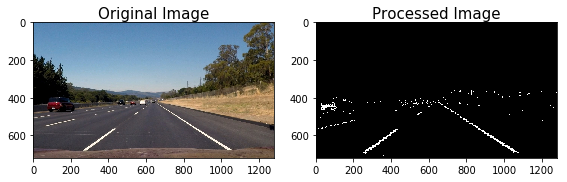

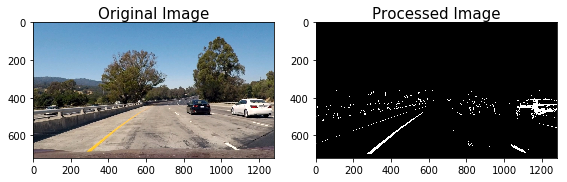

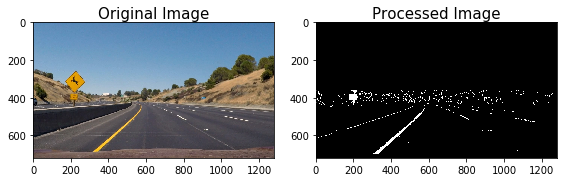

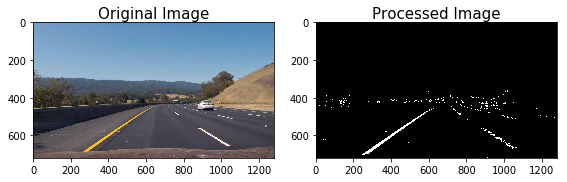

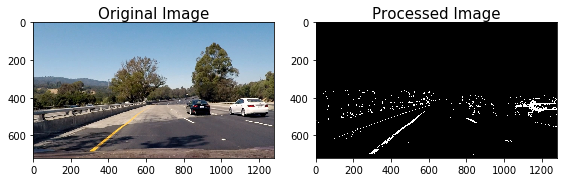

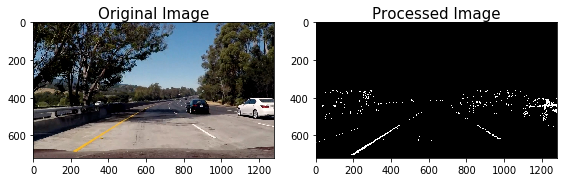

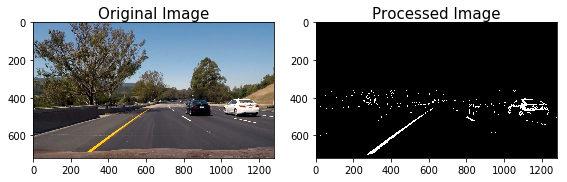

In [99]:
## Test with test images
images = glob.glob('test_images/*.jpg')
images_org = []
images_transform = []

for idx, fname in enumerate(images):
    image = cv2.imread(fname)
    processed_img = preprocessing(image,s_thresh=(180, 255), sx_thresh=(40, 100), sobel_ksize=5)
    images_org.append(image)
    images_transform.append(processed_img)

# Plot the Processed_images
for image_in, image_out in zip(images_org,images_transform):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
    f.tight_layout()
    ax1.imshow(cv2.cvtColor(image_in, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=15)
    ax2.imshow(image_out, cmap='gray')
    ax2.set_title('Processed Image', fontsize=15)

## Perspetive Transform

In [39]:
###############################
# Utility Functions
###############################
def warp(image, src, dst):
    #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = image
    # Grab the image shape
    img_size = (gray.shape[1], gray.shape[0])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(image, M, img_size)
    return warped

(720, 1280)
(720, 1280)


/Users/sliu/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)


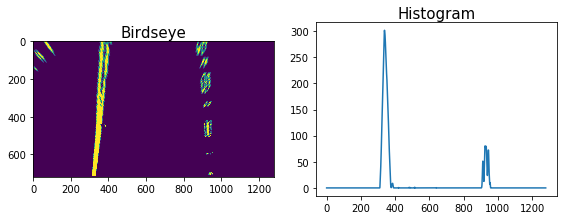

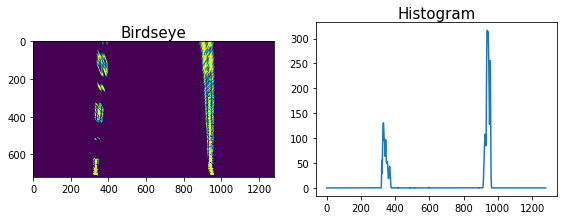

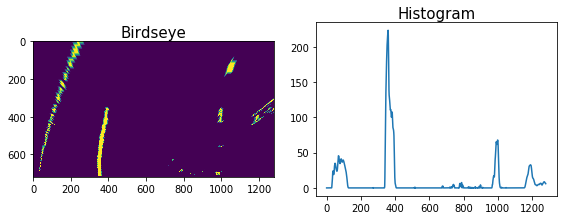

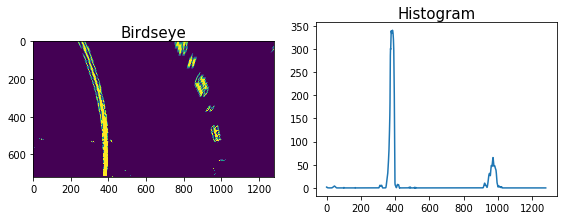

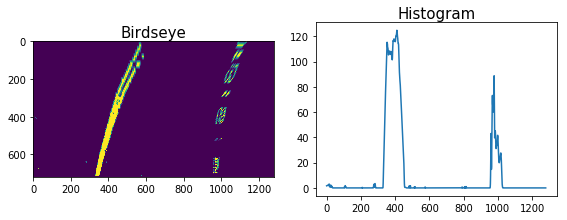

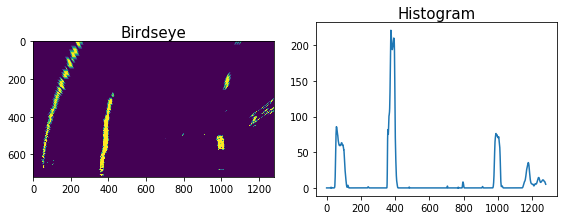

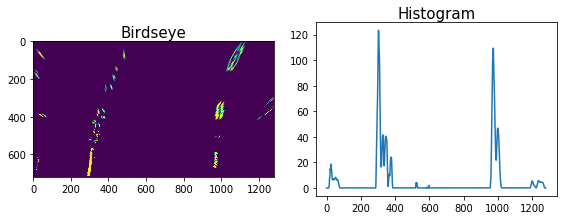

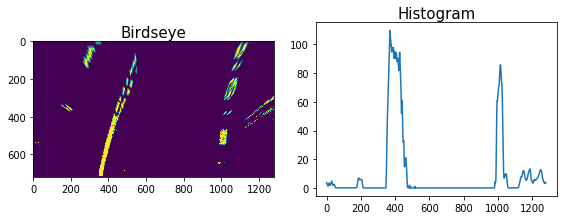

In [100]:
# Perspective transform: Birds-eye view
src = np.float32([[585, 450], [203, 720], [1127, 720], [695, 450]])
dst = np.float32([[320, 0], [320, 720], [960,720], [960, 0]])
images_birdseye = []
Minv_persp = cv2.getPerspectiveTransform(dst, src)

for img in images_transform:
    #perspective transform: birds-eye view
    birdseye = warp(img, src, dst)
    images_birdseye.append(birdseye)
    # curvature detection
    histogram = np.sum(birdseye[birdseye.shape[0]/2:,:], axis=0) 
    #plot the images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
    f.tight_layout()
    ax1.imshow(birdseye)
    ax1.set_title('Birdseye', fontsize=15)
    ax2.plot(histogram)
    ax2.set_title('Histogram', fontsize=15)

## Lane Line detection

In [91]:
# Lane line detection
def fitlines(binary_warped):
    # This function takes a warped binary image called "binary_warped" as input
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255 

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    # If the car drifted from the center of the lane, e.g. change lane, this assumption would break
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), color=(255,255,255), thickness=10) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),color=(255,255,255), thickness=10) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit =[]
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
    
    if len(rightx) == 0:
        right_fit =[]
    else:
        right_fit = np.polyfit(righty, rightx, 2)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return left_fit, right_fit,out_img

In [87]:
#Visualization of lines fitted
for binary_warped in images_birdseye:
    left_fit, right_fit,out_img = fitlines(binary_warped)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #plot the images
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 9))
    f.tight_layout()
    ax1.imshow(binary_warped,cmap='gray')
    ax1.set_title('Birdseye', fontsize=15)
    
    ax2.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    ax2.set_title('Polyfit', fontsize=15)
    
    binary_warped2 = np.zeros((720, 1280,3))
    binary_warped2[:,:,0] = binary_warped
    binary_warped2[:,:,1] = binary_warped
    binary_warped2[:,:,2] = binary_warped
    ax3.imshow(out_img)
    result = cv2.addWeighted(binary_warped2, .8, out_img, .8, 0)
    ax3.imshow(result)
    ax3.set_title('Combined', fontsize=15)

sharon: in fit line


/Users/sliu/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


AttributeError: 'numpy.ndarray' object has no attribute 'binary_warped'

In [75]:
def fit_continuous(left_fit, right_fit, binary_warped):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit_updated =[]
    else:
        left_fit_updated = np.polyfit(lefty, leftx, 2)
        
    if len(rightx) == 0:
        right_fit_updated =[]
    else:
        right_fit_updated = np.polyfit(righty, rightx, 2)
        
    return  left_fit_updated, right_fit_updated

sharon: in fit line, binary_warped
(720, 1280)


(720, 0)

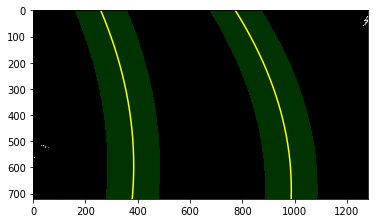

In [132]:
# Test fit_continuours
binary_warped = images_birdseye[3]
left_fit, right_fit,out_img = fitlines(binary_warped)
left_fit, right_fit =fit_continuous(left_fit, right_fit, binary_warped)

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)

nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [76]:
#Calc Curvature
def curvature(left_fit, right_fit, binary_warped):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension


    # Fit new polynomials to x,y in world space
    #leftx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    #rightx = right_fit[0]*ploty**2+right_fit[1]*ploty+left_fit[2]
        
    #left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    #right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    center = (((left_fit[0]*720**2+left_fit[1]*720+left_fit[2]) +(right_fit[0]*720**2+right_fit[1]*720+right_fit[2]) ) /2 - 640)*xm_per_pix
    
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    return left_curverad, right_curverad, center


In [77]:
#Draw line and return image
def drawLine(undist, warped,left_fit, right_fit):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    # Fit new polynomials to x,y in world space
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2] 
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv_persp, (color_warp.shape[1], color_warp.shape[0])) 

    # Combine the result with the original image
    
    #print("undist", undist.shape)
    #print("newwarp", newwarp.shape)
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    #result = cv2.addWeighted(undist, 0, newwarp, 1, 0)
    return(result, color_warp)

/Users/sliu/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


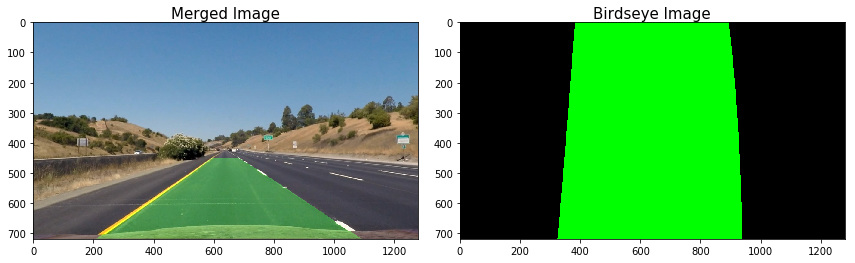

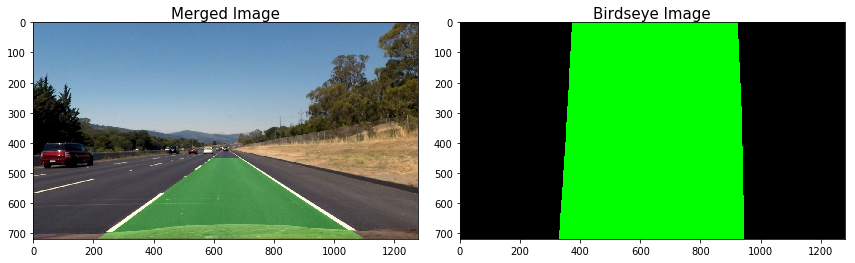

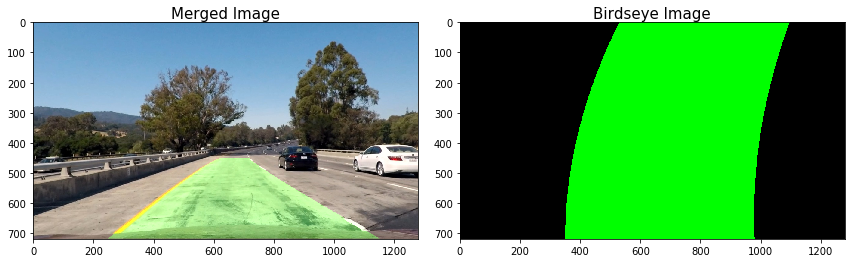

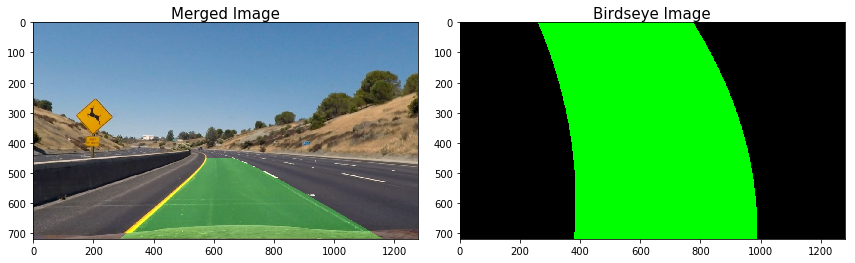

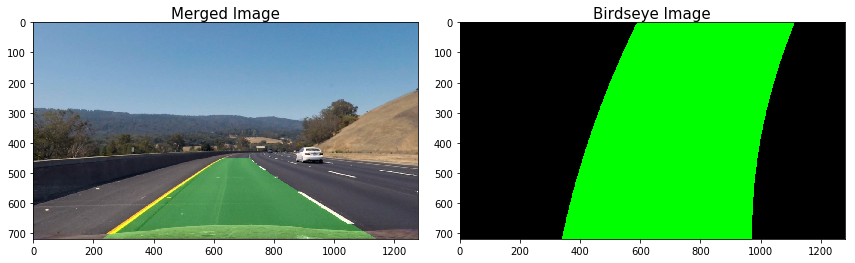

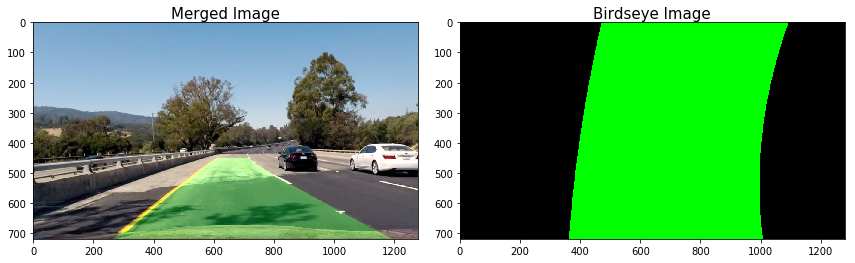

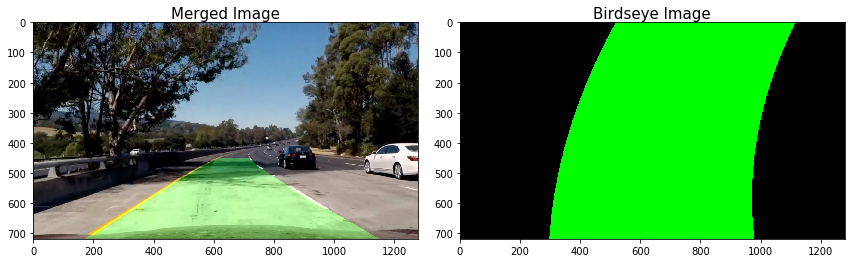

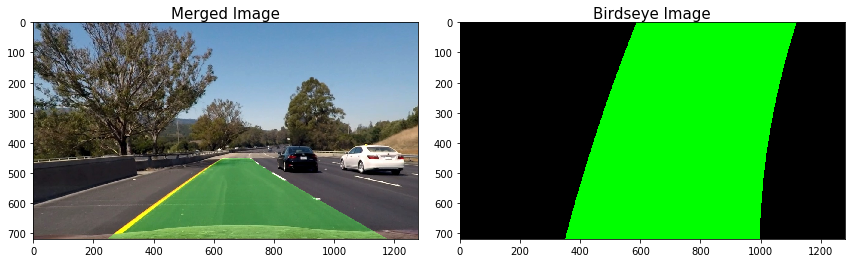

In [78]:
# test drawLine
#Visualization of lines fitted
for binary_warped,undist in zip(images_birdseye, images_undist):
    left_fit, right_fit,out_img = fitlines(binary_warped)
    left_curv, right_curv, center_off = curvature(left_fit, right_fit, binary_warped)
    
    #Warp back to original and merge with image    
    img_merge, img_birds = drawLine(undist, binary_warped,left_fit, right_fit)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 9))
    f.tight_layout()
    ax1.imshow(cv2.cvtColor(img_merge, cv2.COLOR_BGR2RGB))
    ax1.set_title('Merged Image', fontsize=15)
    ax2.imshow(cv2.cvtColor(img_birds, cv2.COLOR_BGR2RGB))
    ax2.set_title('Birdseye Image', fontsize=15)


In [79]:
def sanity_check(left_fit, right_fit, minSlope, maxSlope):
    #Performs a sanity check on the lanes
    #Check 1: check if left and right fits exists
    #Check 2: Calculates the tangent between left and right in two points, and check if it is in a reasonable threshold
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    if len(left_fit) ==0 or len(right_fit) == 0:
        status = False
        d0=0
        d1=0
        #Previous fitlines routine returns empty list to them if not finds
    else:
        #Difference of slope
        L_0 = 2*left_fit[0]*460+left_fit[1]
        R_0 = 2*right_fit[0]*460+right_fit[1]
        d0 =  np.abs(L_0-R_0)

        L_1 = 2*left_fit[0]*720+left_fit[1]
        R_1 = 2*right_fit[0]*720+right_fit[1]
        d1 =  np.abs(L_1-R_1)

        if d0>= minSlope and d0<= maxSlope and d1>= minSlope and d1<= maxSlope:
            status = True
        else:
            status = False
            
    return(status, d0, d1)
        

In [113]:
#Function to process the image
global counter
counter=0
ref_left =np.array([-0.0001,0,400])
ref_right=np.array([-0.0001,0,1000])   
left_fit =np.array([-0.0001,0,400])
right_fit=np.array([-0.0001,0,1000])   

def process_image(image):
    
    #1.Undistortion
    undist = cal_undistort(image, mtx, dist)    
    
    #2.Color and Gradient Transformation
    #processed_img = preprocessing(image,s_thresh=(180, 255), sx_thresh=(40, 100), sobel_ksize=5)
    color_binary = Color_and_Gradient_Thresh(undist,  s_thresh=(180, 255), sx_thresh=(40, 100), sobel_ksize=5)
    
    #3. Birds-eye
    #Perspective array pre-calculated
    src = np.float32([[585, 450], [203, 720], [1127, 720], [695, 450]])
    dst = np.float32([[320, 0], [320, 720], [960,720], [960, 0]])
    binary_warped = warp(processed_img, src, dst)
    print(binary_warped.shape)

    global counter
    #4. Detect lanes and return fit curves
    if counter==0:
        left_fit, right_fit,out_imgfit = fitlines(binary_warped)
    else:
        left_fit, right_fit = fit_continuous(left_fit, right_fit, binary_warped)

    print(left_fit.shape)

    #Project video (2.8, 3.5)
    status_sanity, d0, d1 =sanity_check(left_fit, right_fit, 0, .55)
    #Challenge video (2.4,3.1)
    #status_sanity, d0, d1, d2 =sanity_check(left_fit, right_fit, 2.4,3.1)
    
    #Calc curvature and center
    if status_sanity  == True:        
        #Save as last reliable fit
        ref_left, ref_right = left_fit, right_fit        
        counter+=1
    else:        
        #Use the last realible fit
        left_fit, right_fit = ref_left, ref_right

    left_curv, right_curv, center_off = curvature(left_fit, right_fit, binary_warped)

    #Warp back to original and merge with image    
    img_merge, img_birds = drawLine(undist, binary_warped,left_fit, right_fit)

    #Composition of images to final display
    img_out=np.zeros((576,1280,3), dtype=np.uint8)

    img_out[0:576,0:1024,:] =cv2.resize(img_merge,(1024,576))
    
    #b) Threshold
    img_out[0:288,1024:1280, 0] =cv2.resize(color_binary*255,(256,288))
    img_out[0:288,1024:1280, 1] =cv2.resize(color_binary*255,(256,288))
    img_out[0:288,1024:1280, 2] =cv2.resize(color_binary*255,(256,288))
   
    #c)Birds eye view
    img_out[310:576,1024:1280,:] =cv2.resize(img_birds,(256,266))
    
    #Write curvature and center in image
    TextL = "Left curv: " + str(int(left_curv)) + " m"
    TextR = "Right curv: " + str(int(right_curv))+ " m"
    TextC = "Center offset: " + str(round( center_off,2)) + "m"
    #TextAux = str(status_sanity) + ", d0: " + str(round(d0,2)) + ", d1: " + str(round(d1,2))
    fontScale=1
    thickness=2
    
    fontFace = cv2.FONT_HERSHEY_SIMPLEX

    cv2.putText(img_out, TextL, (130,40), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, TextR, (130,70), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, TextC, (130,100), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    #cv2.putText(img_out, TextAux, (100,130), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)

    cv2.putText(img_out, "Thresh. view", (1070,30), fontFace, .8,(200,200,0), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, "Birds-eye", (1080,305), fontFace, .8,(200,200,0), thickness,  lineType = cv2.LINE_AA)
        
    
    #return img_out, binary_warped, left_curv, right_curv, left_fit, right_fit   
    return img_out 

(720, 1280, 3)


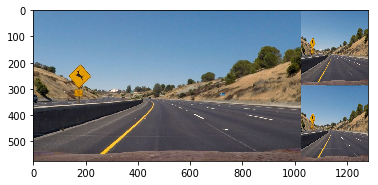

In [114]:
#Test composition images
img = cv2.imread("test_images/test2.jpg")
print(img.shape)
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_out=np.zeros((576,1280,3), dtype=np.uint8)

img_out[0:576,0:1024,0:3] =cv2.resize(imgRGB,(1024,576))
#b) Threshold
img_out[0:288,1024:1280, :] =cv2.resize(imgRGB,(256,288))
#c)Birds eye view
img_out[288:576,1024:1280,:] =cv2.resize(imgRGB,(256,288))

#img2 = cv2.resize(imgRGB,(1024,576))
plt.imshow(img_out)

(720, 1280)
sharon: fitlines
sharon: in fit line, binary_warped
(720, 1280)
(3,)


/Users/sliu/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


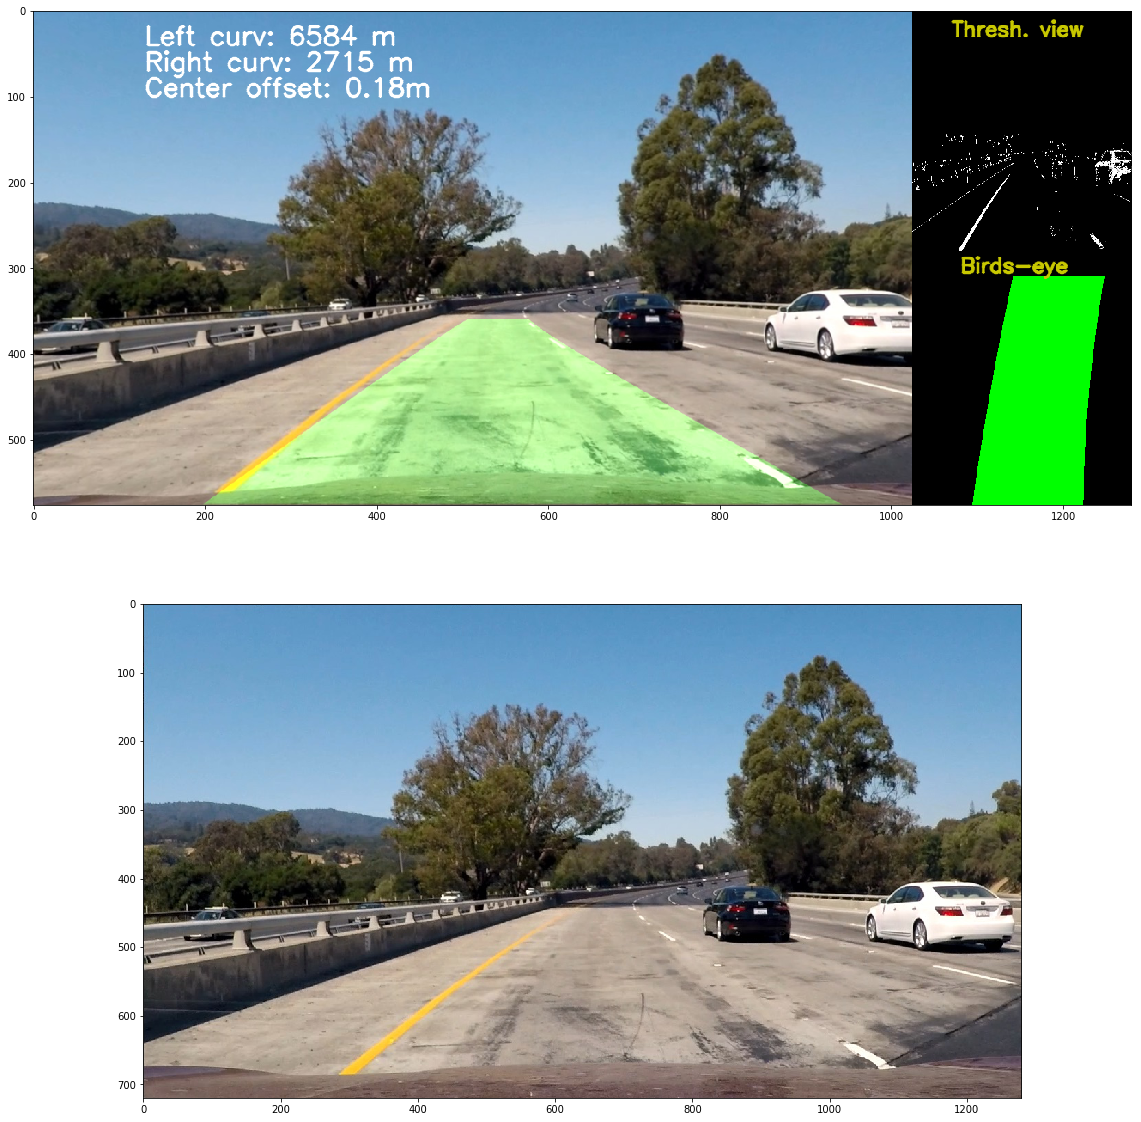

In [115]:
img = cv2.imread("test_images/test1.jpg")
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img2= process_image(imgRGB)

plt.figure(figsize=(30,20))
plt.subplot(2,1,1)
plt.imshow(img2)
plt.subplot(2,1,2)
plt.imshow(imgRGB)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`project_video.mp4`

`challenge_video.mp4`

`harder_challenge_video.mp4`

In [119]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [120]:
# def process_image(image):
#     # NOTE: The output you return should be a color image (3 channel) for processing video below
#     # TODO: put your pipeline here,
#     # you should return the final output (image with lines are drawn on lanes)
#     imshape = image.shape
#     #lines_edges = findLaneLines(image,5,50,150,\
#                   #vertices,10, np.pi/180, 10, 35,20)
#     output = image
#     return output

In [121]:
project_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False)

(720, 1280)
sharon:fit_continuous


UnboundLocalError: local variable 'left_fit' referenced before assignment

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

In [ ]:
project_output